<a href="https://colab.research.google.com/github/DivyaMeenaSundaram/Deep_Learning_Lab/blob/main/Bird_counting_YOLO_Comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!pip install ultralytics opencv-python

In [34]:
import cv2
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from IPython.display import Video


In [36]:
models_to_test = {
    "YOLOv8n": "yolov8n.pt",
    "YOLOv9t": "yolov9t.pt",
    "YOLOv10n": "yolov10n.pt",
    "YOLOv11n": "yolo11n.pt",
    "YOLOv26n": "yolo26n.pt"
}

In [37]:
def run_experiment(model_name, model_path, video_path):

    print(f"\nRunning {model_name}...")

    model = YOLO(model_path)

    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Video error"

    # Video properties
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    if fps == 0:
        fps = 30

    output_name = f"output_{model_name}.avi"

    out = cv2.VideoWriter(
        output_name,
        cv2.VideoWriter_fourcc(*"XVID"),
        fps,
        (w, h)
    )

    print("Writer opened:", out.isOpened())

    max_unique_birds = 0
    frame_counter = 0

    start_time = time.time()

    while cap.isOpened():

        ret, frame = cap.read()
        if not ret:
            break

        results = model.track(
            frame,
            persist=True,
            classes=[14],      # bird class
            conf=0.15,
            iou=0.5,
            imgsz=1280,
            tracker="bytetrack.yaml",
            verbose=False
        )

        annotated_frame = results[0].plot()

        current_count = 0
        if results[0].boxes is not None:
            current_count = len(results[0].boxes)

        if current_count > max_unique_birds:
            max_unique_birds = current_count

        # Overlay Unique Birds
        cv2.rectangle(annotated_frame, (10, 10), (220, 60), (0, 0, 0), -1)

        cv2.putText(
            annotated_frame,
            f"Unique Birds: {max_unique_birds}",
            (20, 45),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.7,
            (0, 255, 0),
            2
        )

        out.write(annotated_frame)
        frame_counter += 1

    elapsed = time.time() - start_time
    fps_speed = frame_counter / elapsed if elapsed > 0 else 0

    cap.release()
    out.release()
    cv2.destroyAllWindows()

    print(f"{model_name} → Birds: {max_unique_birds}, FPS: {fps_speed:.2f}")

    return output_name, max_unique_birds, fps_speed


In [38]:
video_path = "bird4.mp4"

results_summary = []
output_files = {}

for name, path in models_to_test.items():

    output_file, count, speed = run_experiment(name, path, video_path)

    output_files[name] = output_file

    results_summary.append({
        "Model": name,
        "Unique Birds": count,
        "FPS": speed
    })


Running YOLOv8n...
Writer opened: True
YOLOv8n → Birds: 69, FPS: 1.67

Running YOLOv9t...
Writer opened: True
YOLOv9t → Birds: 77, FPS: 1.41

Running YOLOv10n...
Writer opened: True
YOLOv10n → Birds: 84, FPS: 1.91

Running YOLOv11n...
Writer opened: True
YOLOv11n → Birds: 82, FPS: 1.97

Running YOLOv26n...
Writer opened: True
YOLOv26n → Birds: 77, FPS: 2.05


In [39]:
for name, file in output_files.items():

    mp4_file = file.replace(".avi", ".mp4")

    print("Converting:", file)

    !ffmpeg -y -i "{file}" -vcodec libx264 "{mp4_file}"

    output_files[name] = mp4_file

Converting: output_YOLOv8n.avi
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-l

In [40]:
Video(list(output_files.values())[0], embed=True)

In [41]:
from google.colab import files

for file in output_files.values():
    files.download(file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
df = pd.DataFrame(results_summary)
df

,Model,Unique Birds,FPS
0,YOLOv8n,69,1.673315
1,YOLOv9t,77,1.407594
2,YOLOv10n,84,1.908533
3,YOLOv11n,82,1.967516
4,YOLOv26n,77,2.052445


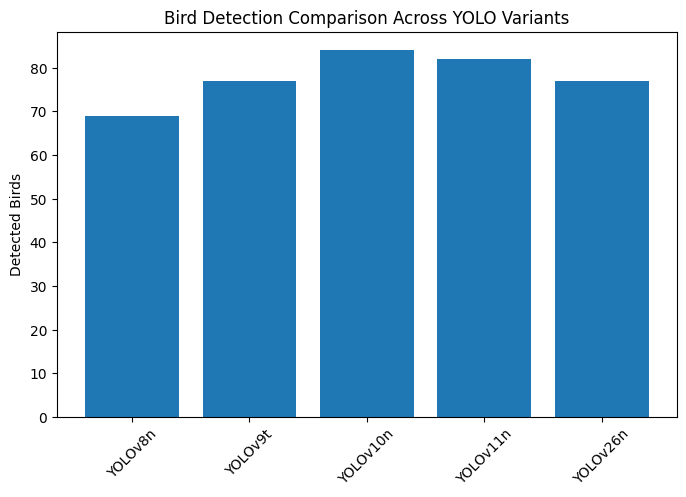

In [43]:
plt.figure(figsize=(8,5))
plt.bar(df["Model"], df["Unique Birds"])
plt.ylabel("Detected Birds")
plt.title("Bird Detection Comparison Across YOLO Variants")
plt.xticks(rotation=45)
plt.show()

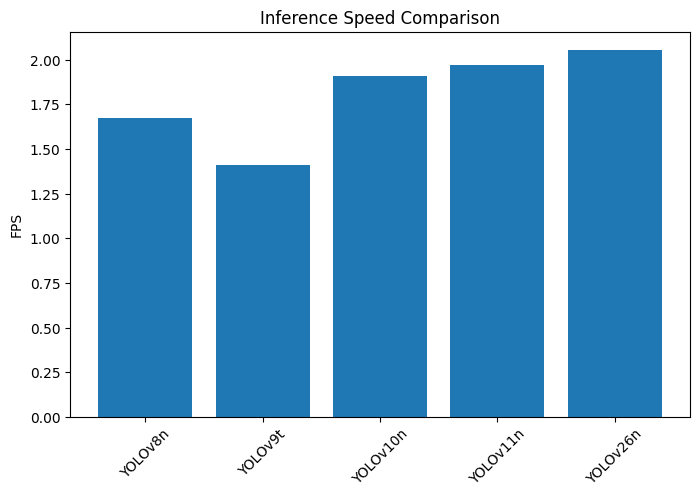

In [44]:
plt.figure(figsize=(8,5))
plt.bar(df["Model"], df["FPS"])
plt.ylabel("FPS")
plt.title("Inference Speed Comparison")
plt.xticks(rotation=45)
plt.show()

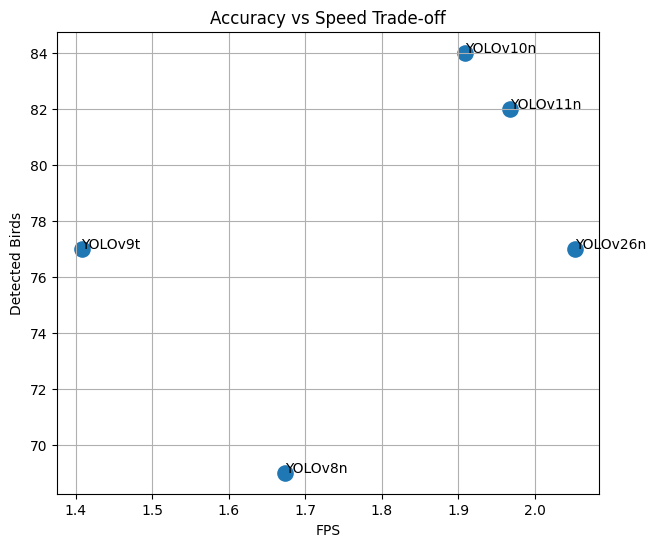

In [45]:
plt.figure(figsize=(7,6))

plt.scatter(df["FPS"], df["Unique Birds"], s=120)

for i, row in df.iterrows():
    plt.text(row["FPS"], row["Unique Birds"], row["Model"])

plt.xlabel("FPS")
plt.ylabel("Detected Birds")
plt.title("Accuracy vs Speed Trade-off")
plt.grid(True)
plt.show()

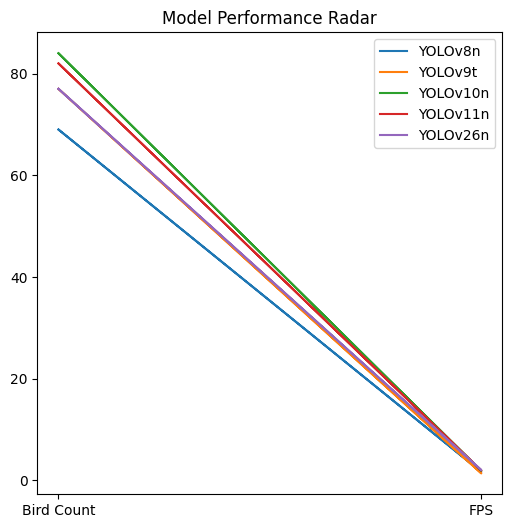

In [46]:
import numpy as np

categories = ["Bird Count", "FPS"]
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)

plt.figure(figsize=(6,6))

for i, row in df.iterrows():
    values = [row["Unique Birds"], row["FPS"]]
    values += values[:1]
    ang = list(angles) + [angles[0]]

    plt.plot(ang, values, label=row["Model"])

plt.xticks(angles, categories)
plt.legend()
plt.title("Model Performance Radar")
plt.show()

In [47]:
df.to_csv("yolo_comparison_results.csv", index=False)

In [48]:
files.download("yolo_comparison_results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

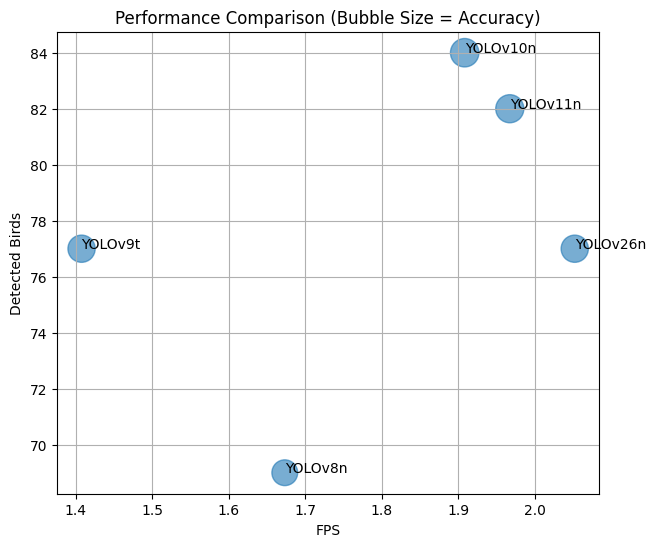

In [50]:
plt.figure(figsize=(7,6))

bubble_size = df["Unique Birds"] * 5   # scale factor

plt.scatter(df["FPS"], df["Unique Birds"], s=bubble_size, alpha=0.6)

for i, row in df.iterrows():
    plt.text(row["FPS"], row["Unique Birds"], row["Model"])

plt.xlabel("FPS")
plt.ylabel("Detected Birds")
plt.title("Performance Comparison (Bubble Size = Accuracy)")
plt.grid(True)

plt.show()

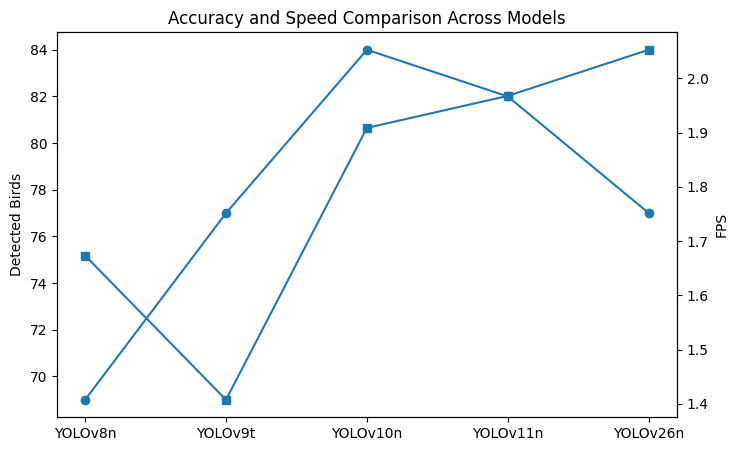

In [51]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(df["Model"], df["Unique Birds"], marker='o')
ax1.set_ylabel("Detected Birds")

ax2 = ax1.twinx()
ax2.plot(df["Model"], df["FPS"], marker='s')
ax2.set_ylabel("FPS")

plt.title("Accuracy and Speed Comparison Across Models")
plt.xticks(rotation=45)

plt.show()

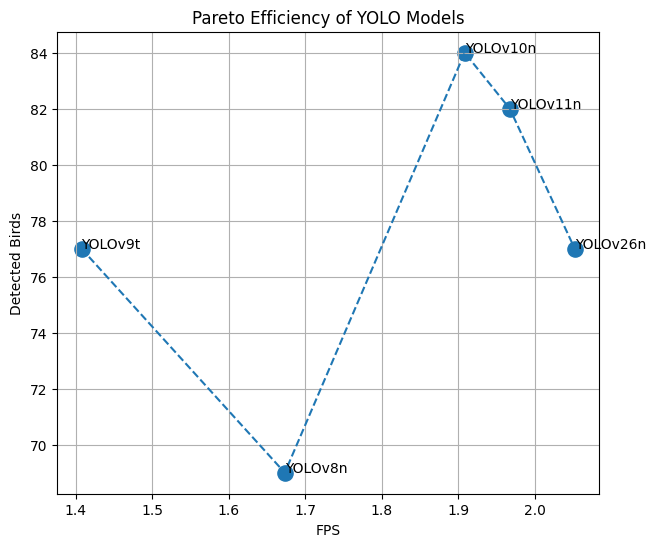

In [53]:
plt.figure(figsize=(7,6))

plt.scatter(df["FPS"], df["Unique Birds"], s=120)

for i, row in df.iterrows():
    plt.text(row["FPS"], row["Unique Birds"], row["Model"])

# Pareto line
sorted_df = df.sort_values("FPS")
plt.plot(sorted_df["FPS"], sorted_df["Unique Birds"], linestyle="--")

plt.xlabel("FPS")
plt.ylabel("Detected Birds")
plt.title("Pareto Efficiency of YOLO Models")
plt.grid(True)

plt.show()